### Loading Packages and Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_9/alabama/2022_11_18_10_15_13/

__pycache__/   keyspace.yaml             output.hdf             settings.py
branches.yaml  logs/                     requirements-COPY.txt
count_data/    model_specification.yaml  requirements.txt


In [4]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_9/alabama/2022_11_18_10_15_13/count_data/

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
population.csv                   ylds.hdf
population.hdf                   ylls.csv
risk_exposure_time.csv           ylls.hdf


In [5]:
sim_results_dir = '/ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_9/alabama/2022_11_18_10_15_13/count_data/'

### Exploring Data

In [6]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0.0
1,1,female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,0.0
2,2,female,2023,acute_ischemic_stroke,deaths,29,outreach_50,25_to_29,0.0
3,3,female,2023,acute_ischemic_stroke,deaths,29,polypill_100,25_to_29,0.0
4,4,female,2023,acute_ischemic_stroke,deaths,29,polypill_50,25_to_29,0.0


In [7]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000.0
1,1,total_population,29,outreach_100,750000.0
2,2,total_population,29,outreach_50,750000.0
3,3,total_population,29,polypill_100,750000.0
4,4,total_population,29,polypill_50,750000.0


In [8]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['angina_susceptible_to_angina_to_angina',
       'ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [13]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
#person_time = state_person_time.loc[state_person_time['scenario'].isin(["baseline"])].reset_index() 
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

512544473.100616

In [10]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

512544473.100616

### Total DALYs by Year

In [14]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year', 'scenario']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,scenario,yll,yld,daly
0,female,25_to_29,29,2023,baseline,1619.857295,145.724076,1765.581371
1,female,25_to_29,29,2023,outreach_100,1619.857295,138.695807,1758.553102
2,female,25_to_29,29,2023,outreach_50,1619.857295,139.138827,1758.996122
3,female,25_to_29,29,2023,polypill_100,1619.857295,140.052246,1759.909541
4,female,25_to_29,29,2023,polypill_50,1619.857295,137.016594,1756.873889


In [15]:
daly_sum = (daly_total
                .groupby(['year', 'scenario'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,scenario,mean,2.5%,97.5%
0,2023,baseline,3782.490340,1710.411477,6105.422081
1,2023,outreach_100,3778.753109,1709.624760,6122.957881
2,2023,outreach_50,3776.838882,1707.106651,6136.740695
3,2023,polypill_100,3775.202364,1707.173693,6154.702056
4,2023,polypill_50,3770.965506,1704.006197,6173.437412


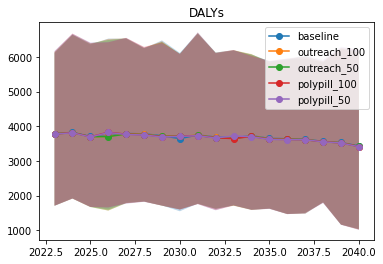

In [16]:
groups = daly_sum.groupby('scenario')
for name, group in groups: 
    plt.plot(group['year'], group['mean'], marker = 'o',label=name)
    plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha = 0.3)
plt.title('DALYs')
plt.legend()

### All Cause Mortality Graphs

In [17]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,5.266667,0.0,31.05
1,25_to_29,female,2023,outreach_100,5.266667,0.0,31.05
2,25_to_29,female,2023,outreach_50,5.266667,0.0,31.05
3,25_to_29,female,2023,polypill_100,5.266667,0.0,31.05
4,25_to_29,female,2023,polypill_50,5.266667,0.0,31.05


In [18]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('raw_mortality_counts_model8.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o',label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            plt.legend()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [19]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw', 'scenario']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,scenario,ptvalue
0,25_to_29,female,2023,29,baseline,27465.7577
1,25_to_29,female,2023,29,outreach_100,27465.7577
2,25_to_29,female,2023,29,outreach_50,27465.7577
3,25_to_29,female,2023,29,polypill_100,27465.7577
4,25_to_29,female,2023,29,polypill_50,27465.7577


In [20]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'scenario']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.001147,0.000866,0.001543
1,25_to_29,female,2023,outreach_100,0.001147,0.000866,0.001543
2,25_to_29,female,2023,outreach_50,0.001147,0.000866,0.001543
3,25_to_29,female,2023,polypill_100,0.001147,0.000866,0.001543
4,25_to_29,female,2023,polypill_50,0.001147,0.000866,0.001543


In [21]:
%%capture 
with PdfPages('acmr_model8.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            plt.legend()
            pdf.savefig(bbox_inches='tight')

In [23]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('acmr_by_year_model8.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [24]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause', 'scenario'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,scenario,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,baseline,0.1,0.0,0.775
1,1,25_to_29,female,2023,acute_ischemic_stroke,outreach_100,0.1,0.0,0.775
2,2,25_to_29,female,2023,acute_ischemic_stroke,outreach_50,0.1,0.0,0.775
3,3,25_to_29,female,2023,acute_ischemic_stroke,polypill_100,0.1,0.0,0.775
4,4,25_to_29,female,2023,acute_ischemic_stroke,polypill_50,0.1,0.0,0.775


In [25]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause', 'scenario']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,scenario,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,baseline,0.0
1,1,25_to_29,female,2023,29,acute_ischemic_stroke,outreach_100,0.0
2,2,25_to_29,female,2023,29,acute_ischemic_stroke,outreach_50,0.0
3,3,25_to_29,female,2023,29,acute_ischemic_stroke,polypill_100,0.0
4,4,25_to_29,female,2023,29,acute_ischemic_stroke,polypill_50,0.0


In [26]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000004,0.0,0.000028
1,25_to_29,female,2023,outreach_100,0.000004,0.0,0.000028
2,25_to_29,female,2023,outreach_50,0.000004,0.0,0.000028
3,25_to_29,female,2023,polypill_100,0.000004,0.0,0.000028
4,25_to_29,female,2023,polypill_50,0.000004,0.0,0.000028


In [27]:
%%capture 
with PdfPages('acute_stroke_csmr_model8.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.ylabel('CSMR for Acute Stroke') 
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [28]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000000,0.000000,0.000000
1,25_to_29,female,2023,outreach_100,0.000000,0.000000,0.000000
2,25_to_29,female,2023,outreach_50,0.000000,0.000000,0.000000
3,25_to_29,female,2023,polypill_100,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2696,95_plus,male,2040,outreach_100,0.007885,0.002571,0.010610
2697,95_plus,male,2040,outreach_50,0.007748,0.002598,0.011366
2698,95_plus,male,2040,polypill_100,0.007804,0.002622,0.011409
2699,95_plus,male,2040,polypill_50,0.007804,0.002622,0.011409


In [29]:
%%capture
with PdfPages('chronic_stroke_csmr_model8.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            plt.ylabel('CSMR for Chronic Stroke') 
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [30]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction', 'angina',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [31]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000127,0.000044,0.000265
1,25_to_29,female,2023,outreach_100,0.000127,0.000044,0.000265
2,25_to_29,female,2023,outreach_50,0.000127,0.000044,0.000265
3,25_to_29,female,2023,polypill_100,0.000127,0.000044,0.000265
4,25_to_29,female,2023,polypill_50,0.000127,0.000044,0.000265


In [32]:
%%capture
with PdfPages('acute_MI_csmr_model8.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            plt.ylabel('CSMR for Acute MI') 
            pdf.savefig(bbox_inches='tight')

We see some divergence with this one! Very small but something more than nothing. 

#### Post Myocaridal Infarction

In [33]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000047,0.0,0.000109
1,25_to_29,female,2023,outreach_100,0.000047,0.0,0.000109
2,25_to_29,female,2023,outreach_50,0.000047,0.0,0.000109
3,25_to_29,female,2023,polypill_100,0.000047,0.0,0.000109
4,25_to_29,female,2023,polypill_50,0.000047,0.0,0.000109


In [34]:
%%capture
with PdfPages('post_MI_csmr_model8.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

Again, we see more than nothing here. Might be more prominent for MI than stroke - I should check the RR values to see this makes sense 

### Angina

In [35]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate_summ = (angina_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

angina_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000029,0.0,0.000092
1,25_to_29,female,2023,outreach_100,0.000029,0.0,0.000092
2,25_to_29,female,2023,outreach_50,0.000029,0.0,0.000092
3,25_to_29,female,2023,polypill_100,0.000029,0.0,0.000092
4,25_to_29,female,2023,polypill_50,0.000029,0.0,0.000092


In [36]:
%%capture
with PdfPages('angina_csmr_model8.pdf') as pdf:
    for sex in angina_rate_summ.sex.unique():
        for year in angina_rate_summ.year.unique():
            plt.figure() 
            subdata = angina_rate_summ.loc[(angina_rate_summ.sex==sex) & (angina_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Angina CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.ylabel('CSMR for Angina') 
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [37]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw', 'scenario']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.033377,0.0,0.08705
1,25_to_29,female,2023,outreach_100,0.033377,0.0,0.08705
2,25_to_29,female,2023,outreach_50,0.033377,0.0,0.08705
3,25_to_29,female,2023,polypill_100,0.033377,0.0,0.08705
4,25_to_29,female,2023,polypill_50,0.033377,0.0,0.08705


In [38]:
%%capture
with PdfPages('post_MI_emr_model8.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [39]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000012,0.000003,0.000022
1,25_to_29,female,2023,outreach_100,0.000012,0.000003,0.000022
2,25_to_29,female,2023,outreach_50,0.000012,0.000003,0.000022
3,25_to_29,female,2023,polypill_100,0.000012,0.000003,0.000022
4,25_to_29,female,2023,polypill_50,0.000012,0.000003,0.000022


In [40]:
%%capture
with PdfPages('acute_stroke_prev_model8.pdf') as pdf:
    for sex in prev_acute_rate_sum.sex.unique():
        for year in prev_acute_rate_sum.year.unique():
            plt.figure() 
            subdata = prev_acute_rate_sum.loc[(prev_acute_rate_sum.sex==sex) & (prev_acute_rate_sum.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Prevalence Rate of Acute Ischemic Stroke: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [41]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [42]:
%%capture
with PdfPages('chronic_stroke_prev_model8.pdf') as pdf:
    for sex in prev_chronic_rate_sum.sex.unique():
        for year in prev_chronic_rate_sum.year.unique():
            plt.figure() 
            subdata = prev_chronic_rate_sum.loc[(prev_chronic_rate_sum.sex==sex) & (prev_chronic_rate_sum.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Prevalence Rate of Chronic Ischemic Stroke: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Myocardial Infarction

In [43]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000043,0.000019,0.000077
1,25_to_29,female,2023,outreach_100,0.000043,0.000019,0.000075
2,25_to_29,female,2023,outreach_50,0.000043,0.000019,0.000077
3,25_to_29,female,2023,polypill_100,0.000043,0.000019,0.000077
4,25_to_29,female,2023,polypill_50,0.000043,0.000019,0.000077


In [44]:
%%capture
with PdfPages('acute_mi_prev_model8.pdf') as pdf:
    for sex in prev_acute_MI_summ.sex.unique():
        for year in prev_acute_MI_summ.year.unique():
            plt.figure() 
            subdata = prev_acute_MI_summ.loc[(prev_acute_MI_summ.sex==sex) & (prev_acute_MI_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Prevalence Rate of Acute MI: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [45]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.001484,0.001179,0.001792
1,25_to_29,female,2023,outreach_100,0.001484,0.001179,0.001792
2,25_to_29,female,2023,outreach_50,0.001484,0.001179,0.001792
3,25_to_29,female,2023,polypill_100,0.001484,0.001179,0.001792
4,25_to_29,female,2023,polypill_50,0.001484,0.001179,0.001792


In [46]:
%%capture
with PdfPages('post_MI_prev_model8.pdf') as pdf:
    for sex in prev_post_MI_summ.sex.unique():
        for year in prev_post_MI_summ.year.unique():
            plt.figure() 
            subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Post MI Prevalence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.1)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of First Time Acute Ischemic Stroke

In [47]:
tran.transition.unique()

array(['angina_susceptible_to_angina_to_angina',
       'ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [48]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,scenario,mean,2.5%,97.5%
0,15,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,baseline,3.8,1.225,7.55
1,16,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,outreach_100,3.8,1.225,7.55
2,17,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,outreach_50,3.8,1.225,7.55
3,18,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_100,3.8,1.225,7.55
4,19,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_50,3.8,1.225,7.55


In [49]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,scenario,ptvalue
0,200,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,baseline,27310.061602
1,201,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,outreach_100,27310.061602
2,202,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,outreach_50,27310.061602
3,203,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,polypill_100,27310.061602
4,204,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,polypill_50,27310.061602


In [50]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw', 'scenario']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000138,0.000044,0.000274
1,25_to_29,female,2023,outreach_100,0.000138,0.000044,0.000274
2,25_to_29,female,2023,outreach_50,0.000138,0.000044,0.000274
3,25_to_29,female,2023,polypill_100,0.000138,0.000044,0.000274
4,25_to_29,female,2023,polypill_50,0.000138,0.000044,0.000274


In [51]:
%%capture
with PdfPages('acute_stroke_inc_model8.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [56]:
%%capture
with PdfPages('acute_stroke_inc_byyear_model8.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for year in tran_rate_sum.year.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute Stroke Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [53]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw', 'scenario']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                  
25_to_29 female 2023 baseline      0.000519  0.000227  0.000965
                     outreach_100  0.000515  0.000227  0.000937
                     outreach_50   0.000519  0.000227  0.000965
                     polypill_100  0.000519  0.000227  0.000965
                     polypill_50   0.000519  0.000227  0.000965

In [57]:
%%capture
with PdfPages('acute_MI_inc_model8.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group.index.get_level_values('age'), group['mean'], marker='o', label=name)
                plt.fill_between(group.index.get_level_values('age'), group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

In [58]:
%%capture
with PdfPages('acute_MI_inc_byyear_model8.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for age in tran_MI_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group.index.get_level_values('year'), group['mean'], marker='o', label=name)
                plt.fill_between(group.index.get_level_values('year'), group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute MI Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### LDL-C Testing - Total Exposure by age/year

In [59]:
risk_exp = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
ldl = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_summ = (ldl
                .groupby(['age', 'sex', 'year','scenario'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,75612.012359,69507.959250,82854.303565
1,25_to_29,female,2023,outreach_100,75513.734396,69423.773487,82723.069555
2,25_to_29,female,2023,outreach_50,75563.196395,69467.108028,82786.014651
3,25_to_29,female,2023,polypill_100,75612.012359,69507.959250,82854.303565
4,25_to_29,female,2023,polypill_50,75612.012359,69507.959250,82854.303565


In [60]:
ldl_rate = ldl.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
ldl_rate = pd.concat([ldl_rate, per_time_group.ptvalue], axis=1)
ldl_rate['ldl_rate'] = ldl_rate['value'] / ldl_rate['ptvalue']
ldl_rate_summ = (ldl_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,2.743886,2.516850,3.000396
1,25_to_29,female,2023,outreach_100,2.740320,2.513802,2.995645
2,25_to_29,female,2023,outreach_50,2.742116,2.515371,2.997924
3,25_to_29,female,2023,polypill_100,2.743886,2.516850,3.000396
4,25_to_29,female,2023,polypill_50,2.743886,2.516850,3.000396


In [61]:
%%capture
with PdfPages('ldl_exposure_model8.pdf') as pdf:
    for sex in ldl_rate_summ.sex.unique():
        for age in ldl_rate_summ.age.unique():
            plt.figure() 
            subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'LDL Exposure: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### High SBP Risk Factor Testing 

In [62]:
sbp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_rate = sbp.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
sbp_rate = pd.concat([sbp_rate, per_time_group.ptvalue], axis=1)
sbp_rate['ldl_rate'] = sbp_rate['value'] / sbp_rate['ptvalue']
sbp_rate_summ = (sbp_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,114.498559,106.643225,120.154352
1,25_to_29,female,2023,outreach_100,114.473728,106.628948,120.118577
2,25_to_29,female,2023,outreach_50,114.485414,106.634544,120.136191
3,25_to_29,female,2023,polypill_100,114.497860,106.643200,120.153259
4,25_to_29,female,2023,polypill_50,114.498223,106.643225,120.154015


In [63]:
%%capture
with PdfPages('sbp_exposure_model8.pdf') as pdf:
    for sex in sbp_rate_summ.sex.unique():
        for age in sbp_rate_summ.age.unique():
            plt.figure() 
            subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'SBP Exposure: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### People on the Intervention

In [65]:
outreach = pd.read_csv(sim_results_dir + 'intervention_person_time.csv')
outreach = outreach.loc[outreach.intervention == 'yes']
outreach = (outreach
                .groupby(['age', 'sex', 'year','scenario'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

outreach.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,baseline,0.000000,0.0,0.000000
1,25_to_29,female,2023,outreach_100,915.253114,0.0,2487.720465
2,25_to_29,female,2023,outreach_50,458.613552,0.0,1243.740452
3,25_to_29,female,2023,polypill_100,177.524983,0.0,429.998357
4,25_to_29,female,2023,polypill_50,87.403696,0.0,211.646270


In [66]:
%%capture
with PdfPages('outreach_time_model8.pdf') as pdf:
    for sex in outreach.sex.unique():
        for age in outreach.age.unique():
            plt.figure() 
            subdata = outreach.loc[(outreach.sex==sex) & (outreach.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Time in Outreach: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')